# [01] CPI Forecast

CPI stands for Consumer Price Index, which reflects the rise in prices in the national economy. Polish CPI (and other indices like HICP) is calculate by Statistics Poland (Central Statistical Office, pl. Główny Urząd Statystyczny). Many of them are reported to Eurostat. Recently, the CPI in Poland establishes new ATH, drawing the attention of citizens to the economic situation of the country. The analysis below is an example of application of ML tools for prediction of time series like Polish CPI. 

CPI is often confused with a money creation by central bank. In Poland, this belief may result from the experience of hyperinflation by citizens in the 1980s, which was actually caused by the printing of money by the central bank of PRL (predecessor of Republic of Poland). In fact, the relationship of the CPI to money creation is very complex and is not subject to analysis.

[Clarification on inflation in official statistics (PL).](https://stat.gov.pl/files/gfx/portalinformacyjny/pl/defaultaktualnosci/5464/18/1/1/co_warto_wiedziec_o_inflacji.pdf)

In [43]:
# Project initialization
from warnings import simplefilter
simplefilter("ignore")

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

## Polish CPI dataset

The dataset was obtained from Macroeconomic Data Bank (pl. Bank Danych Makroekonomicznych), which is created by Statistic Poland. Dataset contains set of price indices monthly reported between january 2000 and september 2021. The column "Wskaźnik" contains name of index, column "Jednostka" type of vaule (corresponding month of the previous year or previous month). Next columns contains values reported in next months beginning from 2000-01. Indices can be calculated in different categories (column Category) or in general (Category=NaN).

In [8]:
dataset = pd.read_csv(
        'dataset/wskazniki_cen_miesieczne.csv', 
        delimiter=";", 
        header=[0,1]
    ).rename(
        columns={
            '\ufeffWskaźnik': 'Wskaźnik',
            'Unnamed: 0_level_1': 'na',
            'Unnamed: 1_level_0': 'Category',
            'Unnamed: 1_level_1': 'na',
            'Unnamed: 2_level_1': 'na'
        }
    )
dataset.head()

Wskaźnik Category  \
                                                  na       na   
0  Wskaźniki cen skupu pszenicy (bez ziarna siewn...      NaN   
1  Wskaźniki cen skupu pszenicy (bez ziarna siewn...      NaN   
2     Wskaźniki cen skupu żyta (bez ziarna siewnego)      NaN   
3     Wskaźniki cen skupu żyta (bez ziarna siewnego)      NaN   
4             Wskaźniki cen skupu bydła (bez cieląt)      NaN   

                                 Jednostka   2000                              \
                                        na     01     02     03     04     05   
0  analogiczny okres roku poprzedniego=100  123,0  127,8  125,9  125,3  133,4   
1                      okres poprzedni=100  109,1  102,2  100,6  100,8  108,2   
2  analogiczny okres roku poprzedniego=100  135,4  135,1  134,7  133,2  138,0   
3                      okres poprzedni=100  108,0  101,1   99,5   98,9  103,9   
4  analogiczny okres roku poprzedniego=100  102,2  103,2  104,3  106,3  108,2   

                 ...   2020   2021                                            \
      06     07  ...     12     01     02     03     04     05     06     07   
0  146,7  146,1  ...  121,4  121,7  124,4  126,9  118,0  117,6  119,4  119,7   
1  113,5   94,5  ...  102,2  104,4  104,4  102,7  100,4  101,4  101,1   88,3   
2  146,1  148,6  ...  108,9  112,6  124,2  131,2  129,0  127,2  133,2  124,8   
3  106,5   91,7  ...  105,5  105,4  103,9  106,9  103,4  101,0  105,9   84,6   
4  111,6  114,2  ...  104,5  101,2  108,2  110,0  117,5  116,6  119,3  117,9   

                 
      08     09  
0  128,8  136,9  
1  102,8  111,0  
2  135,9  136,9  
3  100,5  110,7  
4  127,5  126,6  

[5 rows x 264 columns]

The next step is to extract CPI from indices with Category=NaN for "previous month".

In [10]:
CPI_dataset = dataset[
    (dataset[('Wskaźnik','na')] == 'Wskaźniki cen towarów i usług konsumpcyjnych') # CPI 
    & (dataset[('Category','na')].isna()) # general calculation
    & (dataset[('Jednostka','na')] == 'okres poprzedni=100') # previous month
].drop(
    columns={
        ('Wskaźnik','na'),
        ('Category','na'),
        ('Jednostka','na')
    }
)
CPI_dataset.head()

2000                                                                ...  \
       01     02     03     04     05     06     07    08     09     10  ...   
36  101,8  100,9  100,9  100,4  100,7  100,8  100,7  99,7  101,0  100,8  ...   

     2020   2021                                                          
       12     01     02     03     04     05     06     07     08     09  
36  100,1  101,3  100,5  101,0  100,8  100,3  100,1  100,4  100,3  100,7  

[1 rows x 261 columns]

Time to create time series from data.

In [26]:
# transpose dataframe
CPI_dataset_transposed = CPI_dataset.T.rename(
        columns={36:'value'} # rename value column
    )
# convert string values to float (remove ',')
CPI_dataset_transposed = CPI_dataset_transposed.assign(
    value = CPI_dataset_transposed['value'].map(lambda x: float(x.replace(',','.')))
)
# create timestamp from index
CPI_relative_to_previous_month = CPI_dataset_transposed.assign(
    time = CPI_dataset_transposed.index.map(
        lambda index_value: datetime.strptime(index_value[0]+'-'+index_value[1]+'-01','%Y-%m-%d')
    )
).set_index('time')
CPI_relative_to_previous_month.head()


,value
time,
2000-01-01,101.8
2000-02-01,100.9
2000-03-01,100.9
2000-04-01,100.4
2000-05-01,100.7


In this moment each value is related to previous. For better imaginary of the trend, it should be absolute. (Or related to one point, in this case december 1999.)

In [27]:
CPI_absolute = CPI_relative_to_previous_month.copy()

_last_value = 100
for row in CPI_absolute.iterrows():
    _last_value = row[1]['value']/100 * _last_value
    CPI_absolute.loc[row[0],'value'] = _last_value

CPI_absolute.head()

,value
time,
2000-01-01,101.800000
2000-02-01,102.716200
2000-03-01,103.640646
2000-04-01,104.055208
2000-05-01,104.783595


Lets see the CPI timeseries.

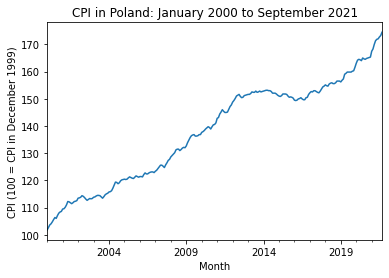

In [55]:
figure = CPI_absolute.plot(
    title='CPI in Poland: January 2000 to September 2021',
    legend=False
)
_ = figure.set(xlabel='Month',ylabel='CPI (100 = CPI in December 1999)')